In [1]:
import environment
import baseline
import utils
import IQL
import visualization
import io_utils

import time
import os

/home/rania/Public/anaconda3/envs/jupyter_base/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
configuration = {
    "max_cycles": 1000, 
    "x_size": 12,"y_size": 12, 
    "shared_reward": True, 
    "n_evaders": 2, "n_pursuers": 8,
    "obs_range": 7, 
    "n_catch": 2, 
    "freeze_evaders": False, 
    "tag_reward": 0.5, "catch_reward": 10.0, "urgency_reward": -1, 
    "surround": True, 
    "constraint_window": 1.0
}

# Fonctions de base

Comme méthodes de base pour la comparaison, on présente :
- Une fonction aléatoire ;
- Une fonction basée sur la proximité aux « evaders » ;
- Une fonction basée sur la proximité aux « evaders » et aux « allies » ;
- Une heuristique d'orientation, ajoutée à cette dernière, qui s'appuie sur le chemin défini par les bordures.

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 1000 steps.


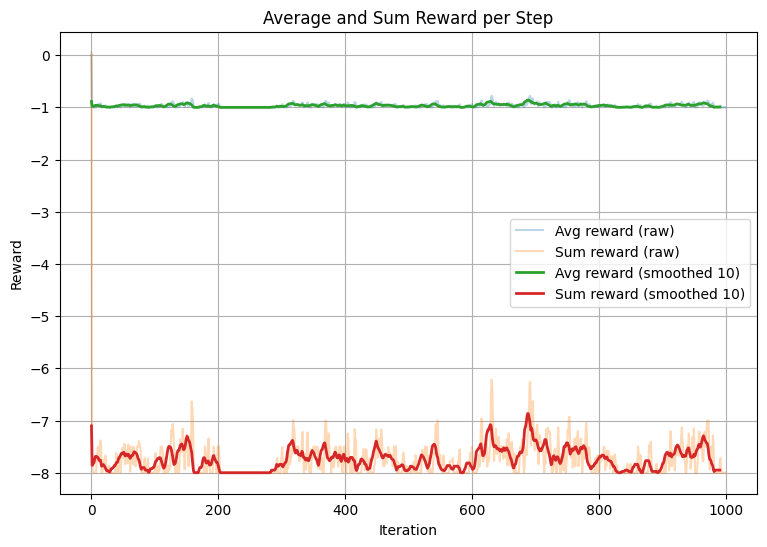

Saved run 33 to data.csv


In [3]:
environment.start_AEC(configuration)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 1000 steps.


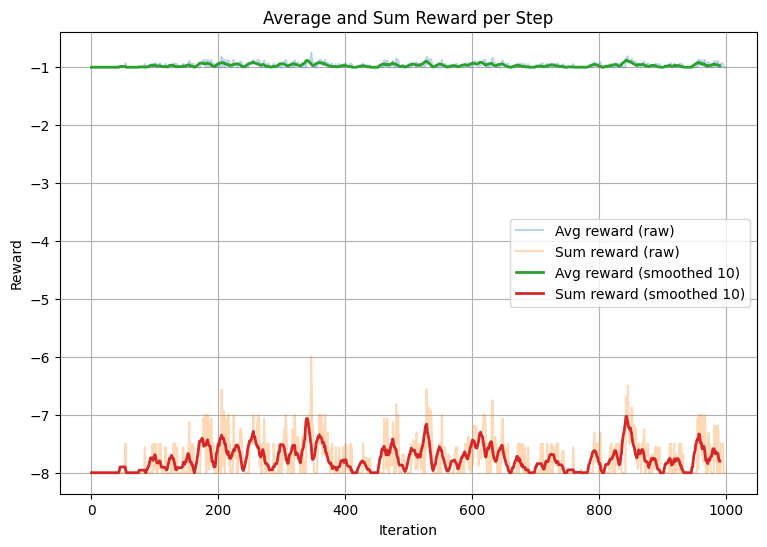

Saved run 42 to data.cvs


In [4]:
environment.start_parallel(configuration)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 1000 steps.


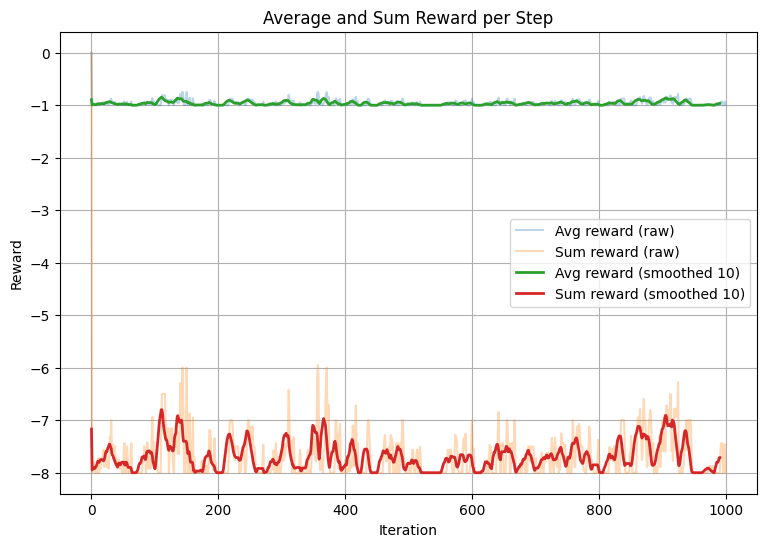

Saved run 34 to data.csv


In [5]:
environment.start_AEC(configuration, baseline.frantic_chase)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 1000 steps.


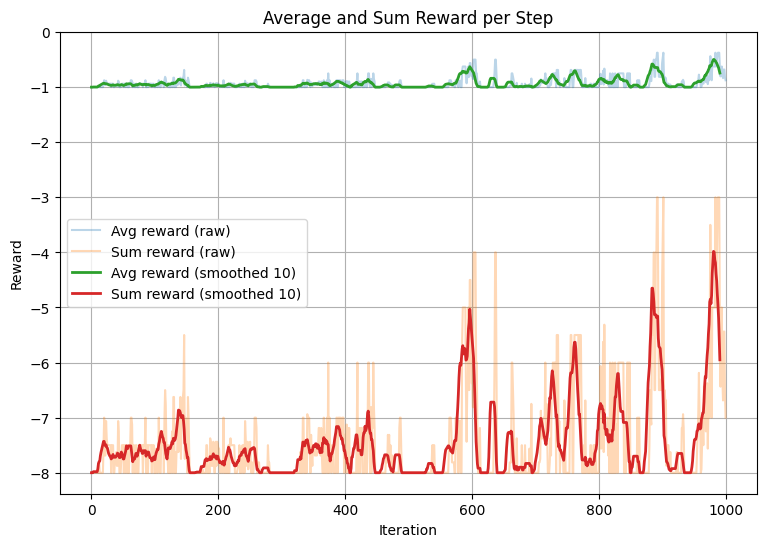

Saved run 43 to data.cvs


In [6]:
environment.start_parallel(configuration, baseline.frantic_chase)

agent pursuer_0 terminated
agent pursuer_1 terminated
agent pursuer_2 terminated
agent pursuer_3 terminated
agent pursuer_4 terminated
agent pursuer_5 terminated
agent pursuer_6 terminated
agent pursuer_7 terminated
pursuit successful after 986 steps!


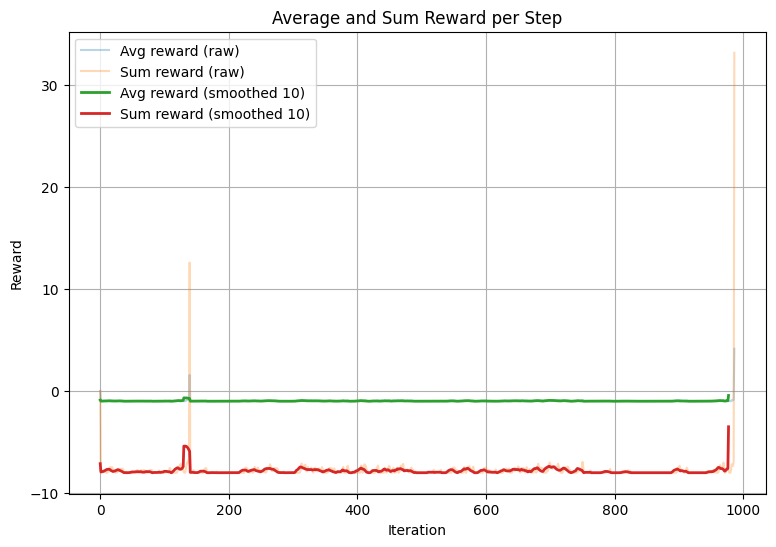

Saved run 35 to data.csv


In [7]:
environment.start_AEC(configuration, baseline.coward_chase)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 1000 steps.


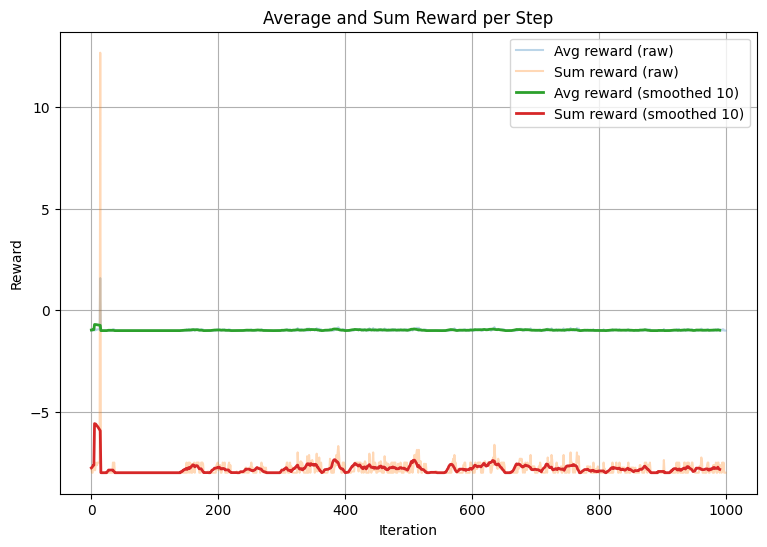

Saved run 44 to data.cvs


In [8]:
environment.start_parallel(configuration, baseline.coward_chase)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 1000 steps.


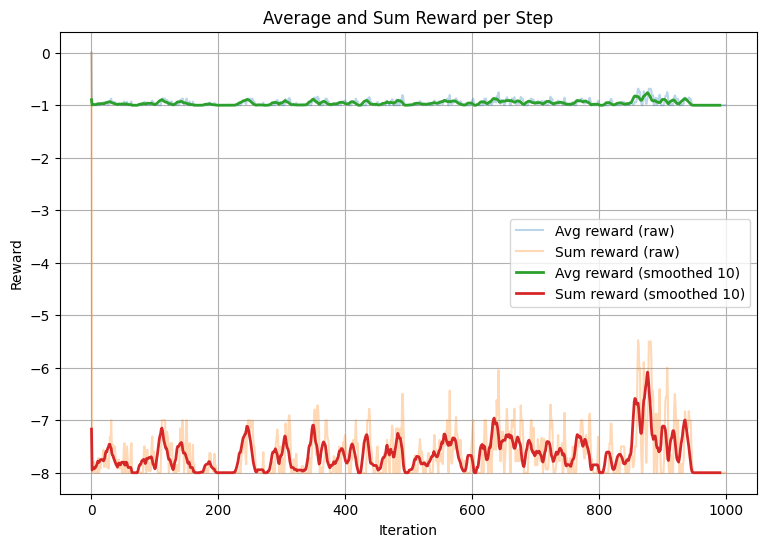

Saved run 36 to data.csv


In [9]:
environment.start_AEC(configuration, baseline.group_chase)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 1000 steps.


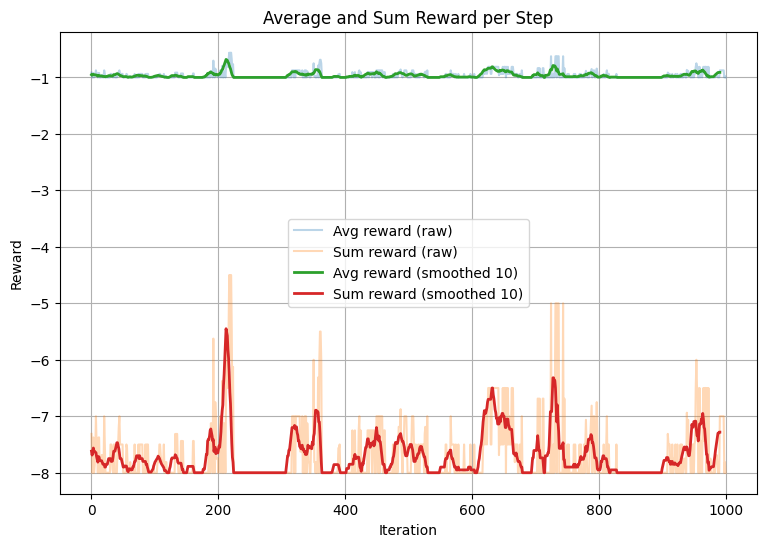

Saved run 45 to data.cvs


In [10]:
environment.start_parallel(configuration, baseline.group_chase)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 1000 steps.


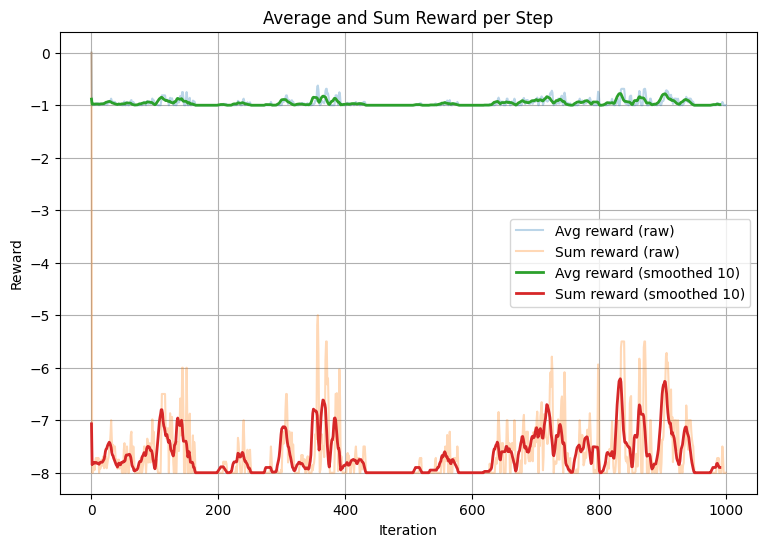

Saved run 37 to data.csv


In [11]:
environment.start_AEC(configuration, baseline.border_guided_group_chase)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 1000 steps.


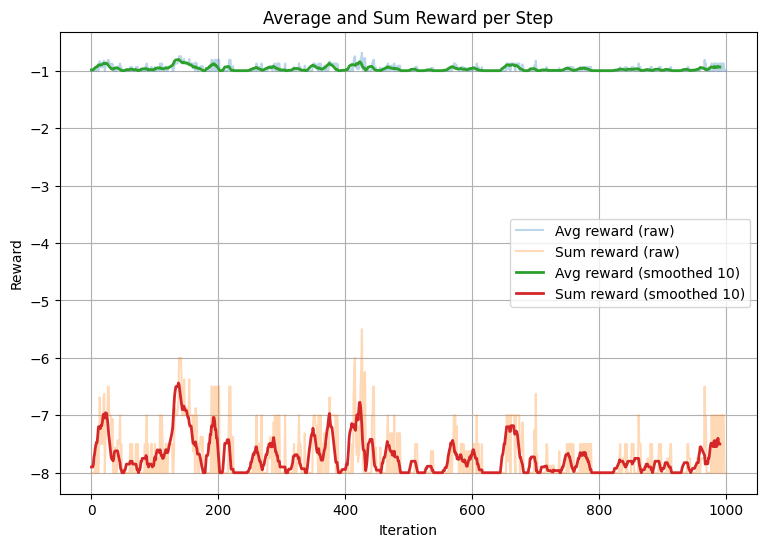

Saved run 46 to data.cvs


In [12]:
environment.start_parallel(configuration, baseline.border_guided_group_chase)

En théorie, la dimension aléatoire des méthodes et de la position des "evaders" fait en sorte qu’on puisse toujours obtenir, théoriquement, un nombre d’essais permettant d'atteindre le but. On peut constater cependant que ce nombre est loin d’être négligeable, surtout pour les instances comportant de nombreuses contraintes à satisfaire (beaucoup d’"evaders" à capturer) et un grand espace d’états possible avec une faible probabilité de tomber sur la même case. On mentionne également qu’il est difficile de définir formellement une stratégie pour entourer un "evader".

# MARL

La première architecture s'appuie sur une approche Independent Q-Learning (IQL), où chaque agent évolue de manière autonome tout en partageant le même environnement global.
- Extraction de Features : Compte tenu de la nature positionnelle des données d'entrée, nous intégrons des couches de Convolutional Neural Networks (CNN) en tête de réseau. Ces couches permettent d'extraire des représentations spatiales pertinentes.
- Gestion de l'Expérience : Pour stabiliser l'apprentissage et briser la corrélation temporelle des données, nous utilisons un Replay Buffer. Les expériences passées y sont stockées et échantillonnées de manière aléatoire.
- Politique de Sélection d'Action : Nous appliquons une stratégie $\epsilon$-greedy. Cette méthode permet de sélectionner l'action maximisant la Q-valeur (exploitation) tout en maintenant un taux d'exploration pour découvrir des stratégies potentiellement plus optimales.
- Stabilité de l'Apprentissage : Chaque agent est doté de deux réseaux distincts (Double DQN architecture) : Le Q-Network, mis à jour à chaque étape. Le Target Network, dont les poids sont gelés et synchronisés périodiquement pour stabiliser le calcul de la fonction de perte.
- Paradigme Multi-Agent : Sous l'approche IQL, chaque agent traite les autres comme faisant partie intégrante de l'environnement (non-stationnarité), apprenant sa propre politique de manière simultanée et décentralisée.

In [13]:
configuration_1 = {
    "max_cycles": 500, 
    "x_size": 12,"y_size": 12, 
    "shared_reward": True, 
    "n_evaders": 2, "n_pursuers": 8,
    "obs_range": 7, 
    "n_catch": 2, 
    "freeze_evaders": False, 
    "tag_reward": 0.5, "catch_reward": 10.0, "urgency_reward": -1, 
    "surround": True, 
    "constraint_window": 1.0
}


model_name = "test_1"
os.makedirs(f"./{model_name}", exist_ok=True)

RETRAIN = True

In [14]:
if RETRAIN:
    start_time = time.perf_counter()
    marl_agents, rewards, lengths, losses, metadata = environment.train_IQL(configuration_1,
                                                                            model_name,
                                                                            n_episodes=80,
                                                                            batch_size=258,
                                                                            epsilon_decay=0.995)
    print(time.perf_counter() - start_time)

Using device: cuda
Observation shape: (7, 7, 3)
Number of actions: 5
Number of agents: 8

IQL training started...
Episode 10/80 | Avg Reward: -482.96 | Avg Length: 500.0 | Epsilon: 0.951
Episode 20/80 | Avg Reward: -481.54 | Avg Length: 500.0 | Epsilon: 0.905
Episode 30/80 | Avg Reward: -481.85 | Avg Length: 500.0 | Epsilon: 0.860
Episode 40/80 | Avg Reward: -480.68 | Avg Length: 500.0 | Epsilon: 0.818
Episode 50/80 | Avg Reward: -464.56 | Avg Length: 482.4 | Epsilon: 0.778
Episode 60/80 | Avg Reward: -481.68 | Avg Length: 500.0 | Epsilon: 0.740
Episode 70/80 | Avg Reward: -483.77 | Avg Length: 500.0 | Epsilon: 0.704
Episode 80/80 | Avg Reward: -481.75 | Avg Length: 500.0 | Epsilon: 0.670

IQL training complete!
1263.8898281289985


Plot saved to ./test_1/training_plot_IQL


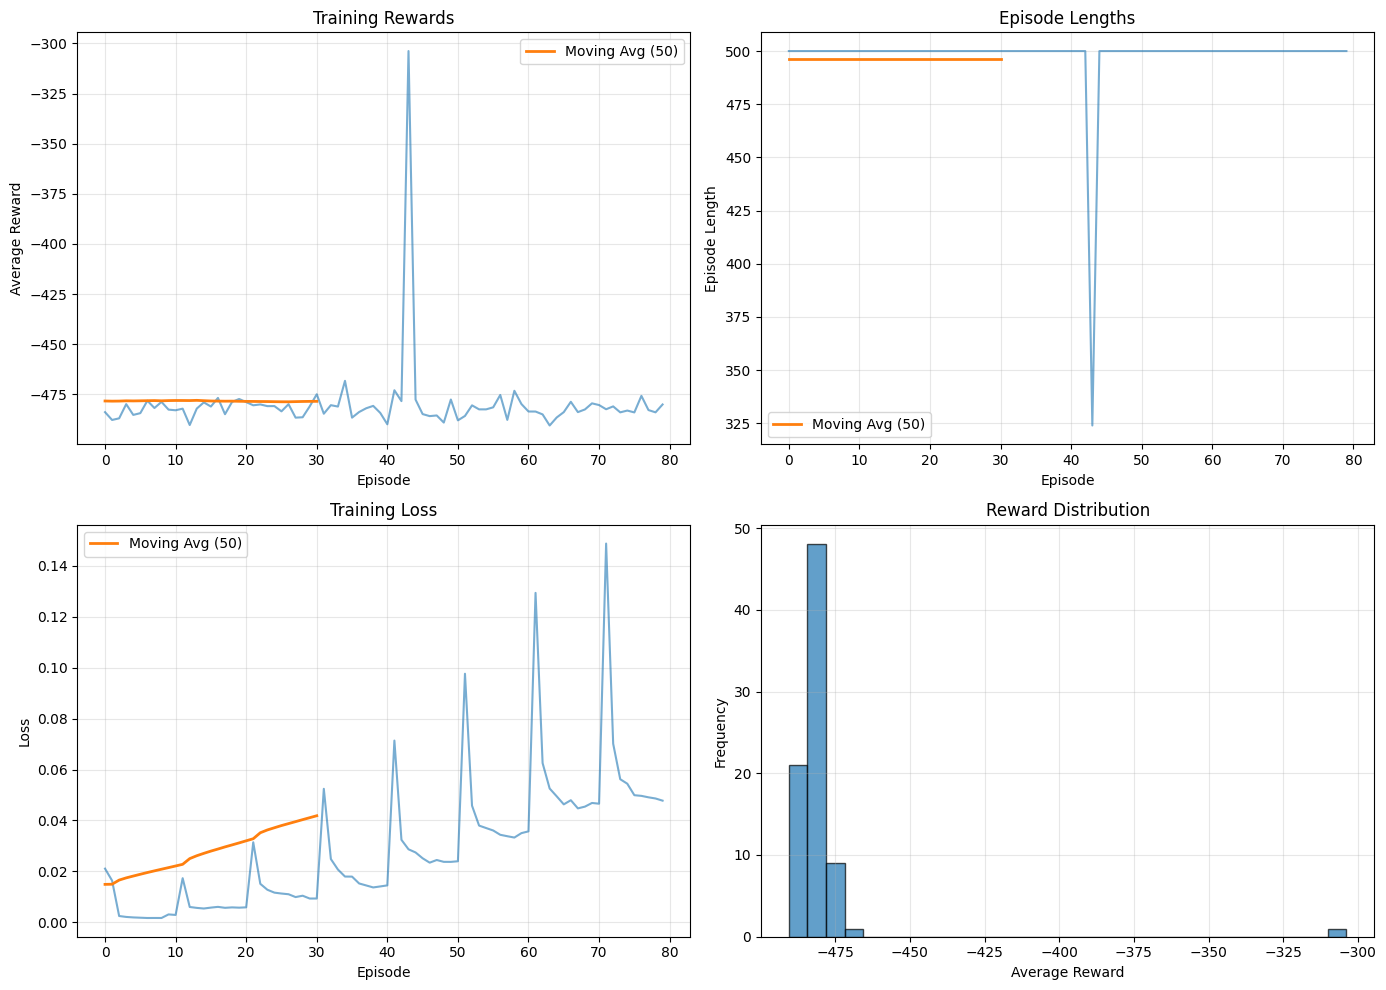

In [15]:
if RETRAIN:
    visualization.plot_training_results(rewards, lengths, losses, save_path=f"./{model_name}/training_plot_IQL")

In [16]:
if RETRAIN:
    rewards, lengths, success, action_counts = environment.eval_IQL(configuration_1, marl_agents, n_episodes=30)


IQL evaluation started...
Episode 1: Avg Reward = -482.28, Steps = 500, Success = 0
Episode 2: Avg Reward = -487.14, Steps = 500, Success = 0
Episode 3: Avg Reward = -483.29, Steps = 500, Success = 0
Episode 4: Avg Reward = -486.34, Steps = 500, Success = 0
Episode 5: Avg Reward = -484.55, Steps = 500, Success = 0
Episode 6: Avg Reward = -483.76, Steps = 500, Success = 0
Episode 7: Avg Reward = -477.59, Steps = 500, Success = 0
Episode 8: Avg Reward = -484.42, Steps = 500, Success = 0
Episode 9: Avg Reward = -477.13, Steps = 500, Success = 0
Episode 10: Avg Reward = -481.27, Steps = 500, Success = 0
Episode 11: Avg Reward = -480.95, Steps = 500, Success = 0
Episode 12: Avg Reward = -479.67, Steps = 500, Success = 0
Episode 13: Avg Reward = -482.92, Steps = 500, Success = 0
Episode 14: Avg Reward = -482.80, Steps = 500, Success = 0
Episode 15: Avg Reward = -481.77, Steps = 500, Success = 0
Episode 16: Avg Reward = -492.56, Steps = 500, Success = 0
Episode 17: Avg Reward = -477.41, Step

Plot saved to ./test_1/eval_plot_IQL


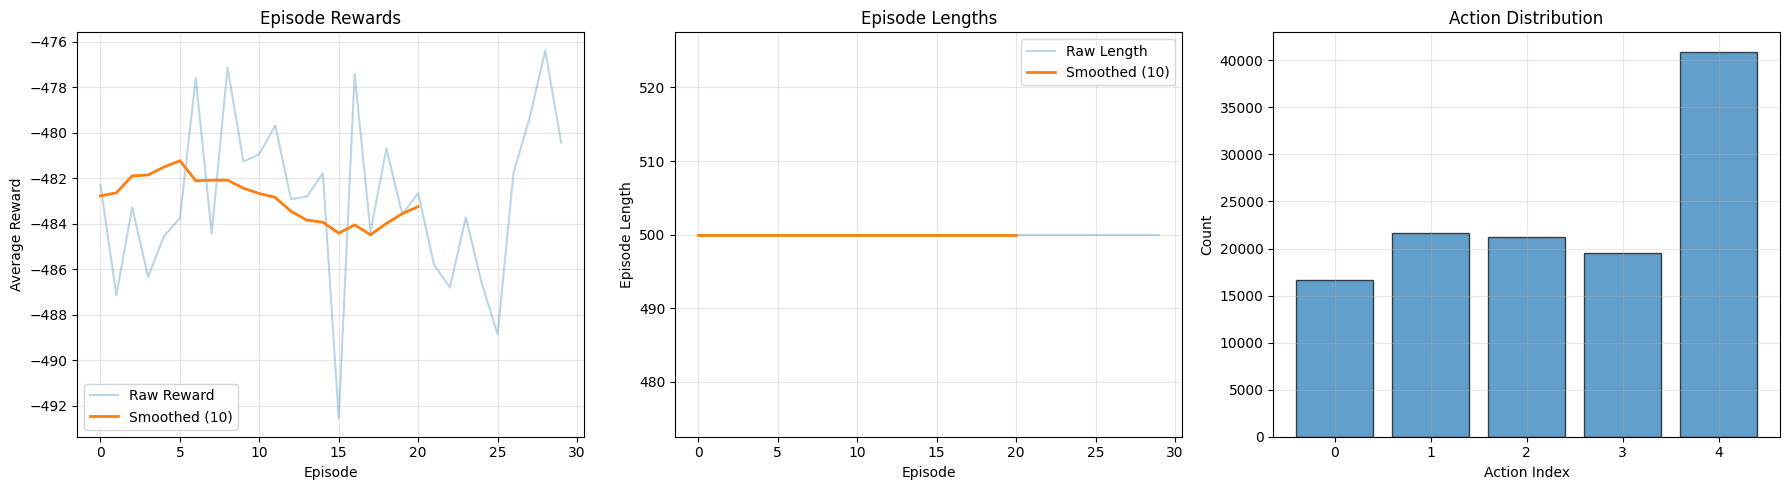

In [17]:
if RETRAIN:
    visualization.plot_eval_metrics(rewards, lengths, action_counts, save_path=f"./{model_name}/eval_plot_IQL")

Alors que l'IQL traite chaque agent comme une entité isolée, rendant la coordination complexe dans un environnement dynamique, QMIX introduit une structure de mélange monolithique. Il permet de réparer l'information perdu en cassant l'hypothèse d'un environnement statique en RL. En utilisant des hyper-réseaux conditionnés par l'état global, QMIX permet une factorisation de la valeur $Q_{tot}$ qui facilite l'assignation du crédit et stabilise l'apprentissage collaboratif.
- Réseaux d'Agents ($Q_a$) : Des réseaux locaux (ici avec CNN) qui traitent les observations individuelles pour produire des utilités de Q-valeurs par agent.

- Mixing Network : Un réseau central qui combine les Q-valeurs de tous les agents en une seule valeur globale ($Q_{tot}$) pour l'équipe.

- Hypernetworks : Des réseaux secondaires qui utilisent l'état global de l'environnement pour générer dynamiquement les poids du Mixing Network.

- Contrainte de Monotonie : L'application d'une fonction absolue (torch.abs) sur les poids du mixeur, garantissant qu'une action individuellement bonne augmente mathématiquement la valeur globale.

- State-Specific Integration : Contrairement à l'IQL, le QMIX utilise des informations globales (positions de tous les acteurs) durant l'entraînement pour mieux distribuer les récompenses (problème du Credit Assignment).

In [18]:
if RETRAIN:
    start_time = time.perf_counter()
    qmix_agent, rewards, lengths, losses, metadata = environment.train_QMIX(configuration_1,
                                                                            model_name,
                                                                            n_episodes=80,
                                                                            batch_size=258,
                                                                            epsilon_decay=0.995)
    print(time.perf_counter() - start_time)

Using device: cuda
Observation shape: (7, 7, 3)
Number of actions: 5
Number of agents: 8

QMIX training started...
Episode 10/80 | Avg Reward: -472.14 | Avg Length: 489.1 | Epsilon: 0.951
Episode 20/80 | Avg Reward: -484.21 | Avg Length: 500.0 | Epsilon: 0.905
Episode 30/80 | Avg Reward: -469.67 | Avg Length: 481.9 | Epsilon: 0.860
Episode 40/80 | Avg Reward: -455.25 | Avg Length: 472.5 | Epsilon: 0.818
Episode 50/80 | Avg Reward: -462.89 | Avg Length: 478.1 | Epsilon: 0.778
Episode 60/80 | Avg Reward: -443.30 | Avg Length: 457.3 | Epsilon: 0.740
Episode 70/80 | Avg Reward: -484.64 | Avg Length: 500.0 | Epsilon: 0.704
Episode 80/80 | Avg Reward: -488.11 | Avg Length: 500.0 | Epsilon: 0.670

QMIX training complete!
Model saved to ./test_1/QMIX.pth
1056.4399357879993


Plot saved to ./test_1/training_plot_QMix


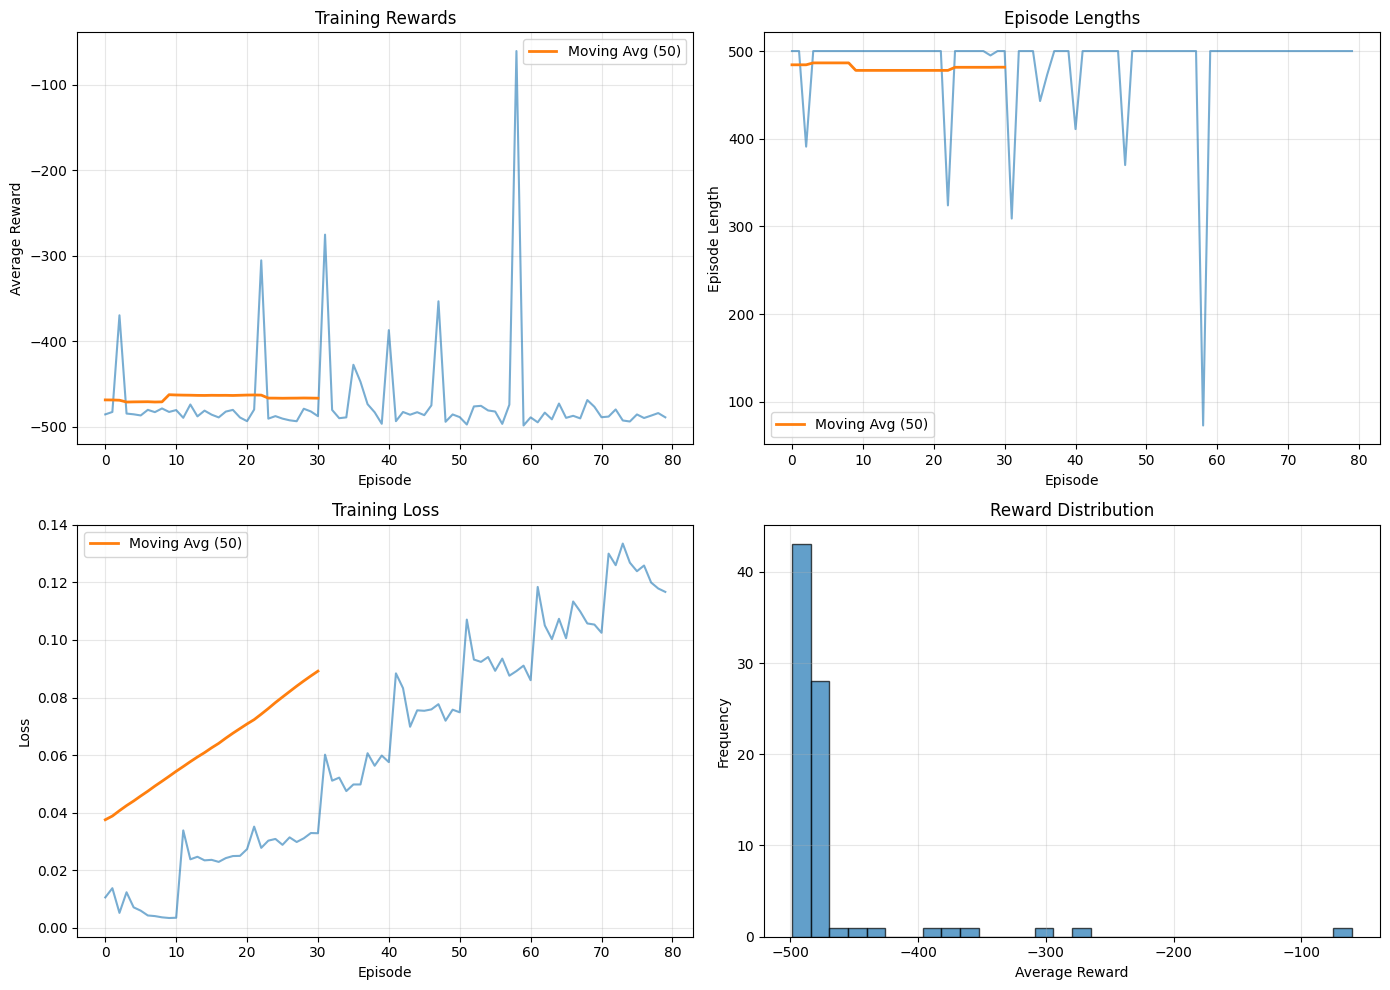

In [19]:
if RETRAIN:
    visualization.plot_training_results(rewards, lengths, losses, save_path=f"./{model_name}/training_plot_QMix")

In [20]:
if RETRAIN:
    rewards, lengths, success, action_counts = environment.eval_QMIX(configuration_1,
                                                                     qmix_agent,
                                                                     n_episodes=30,
                                                                     render=False)


QMIX evaluation started...
Episode 1: Avg Reward = -489.12, Steps = 500, Success = 0
Episode 2: Avg Reward = -486.06, Steps = 500, Success = 0
Episode 3: Avg Reward = -478.58, Steps = 500, Success = 0
Episode 4: Avg Reward = -491.62, Steps = 500, Success = 0
Episode 5: Avg Reward = -486.91, Steps = 500, Success = 0
Episode 6: Avg Reward = -487.41, Steps = 500, Success = 0
Episode 7: Avg Reward = -485.34, Steps = 500, Success = 0
Episode 8: Avg Reward = -493.38, Steps = 500, Success = 0
Episode 9: Avg Reward = -475.78, Steps = 500, Success = 0
Episode 10: Avg Reward = -475.34, Steps = 500, Success = 0
Episode 11: Avg Reward = -472.94, Steps = 500, Success = 0
Episode 12: Avg Reward = -490.38, Steps = 500, Success = 0
Episode 13: Avg Reward = -492.74, Steps = 500, Success = 0
Episode 14: Avg Reward = -484.21, Steps = 500, Success = 0
Episode 15: Avg Reward = -485.91, Steps = 500, Success = 0
Episode 16: Avg Reward = -481.42, Steps = 500, Success = 0
Episode 17: Avg Reward = -487.23, Ste

Plot saved to ./test_1/eval_plot_QMix


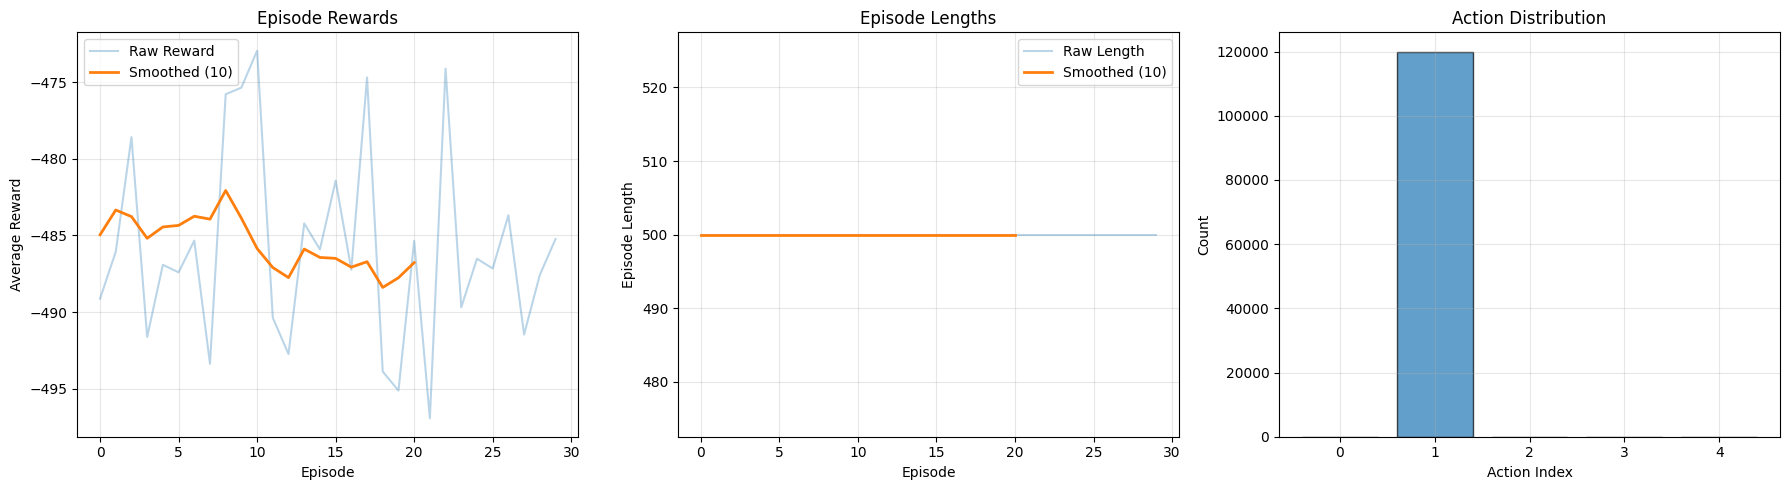

In [21]:
if RETRAIN:
    visualization.plot_eval_metrics(rewards, lengths, action_counts, save_path=f"./{model_name}/eval_plot_QMix")

In [22]:
marl_agents = io_utils.load_IQL(model_name, configuration_1)
qmix_agent = io_utils.load_QMIX(f"./{model_name}/QMIX.pth")
iql_policy = io_utils.marl_agents_to_policy(marl_agents, epsilon=0.0)
qmix_policy = io_utils.qmix_agent_to_policy(qmix_agent, epsilon=0.0)

Using device: cuda
Loaded IQL agents from 'test_1'
Loaded QMIX agent from './test_1/QMIX.pth'


agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 1000 steps.


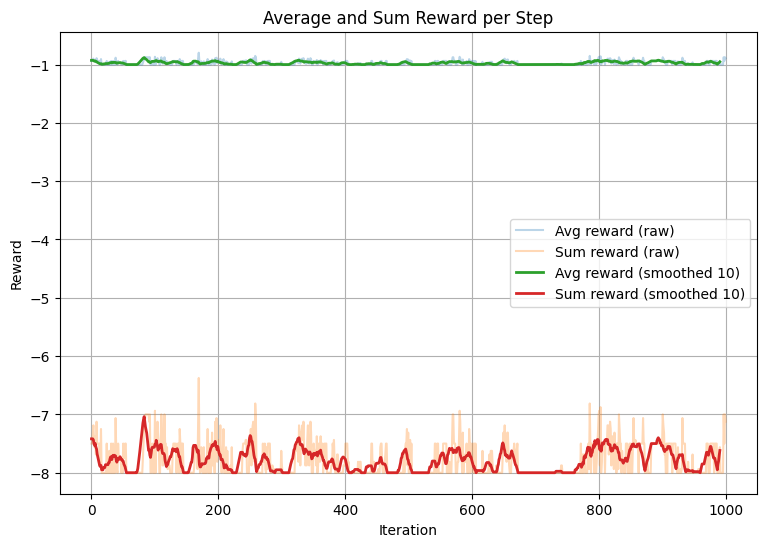

Saved run 47 to data.cvs


In [23]:
environment.start_parallel(configuration, iql_policy)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 1000 steps.


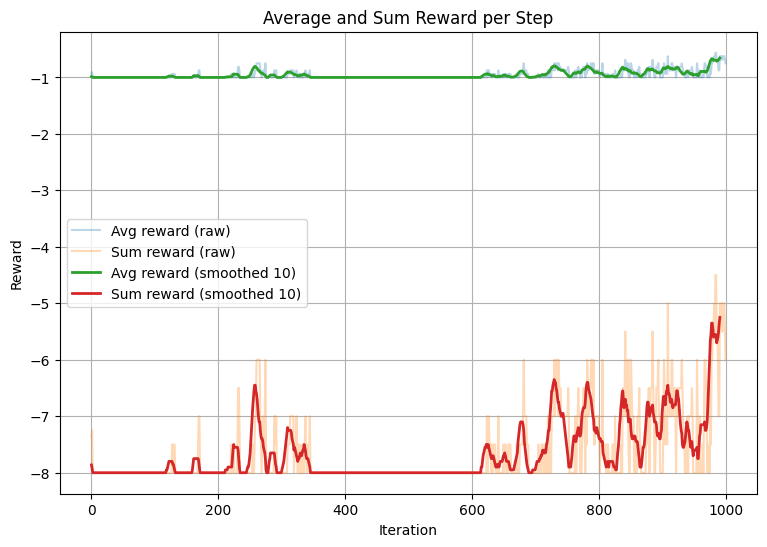

Saved run 48 to data.cvs


In [24]:
environment.start_parallel(configuration, qmix_policy)

On s'attend à ce que:
- Performance (Récompenses): QMIX devrait surpasser IQL, surtout si le nombre d'agents augmente et d'où la coopération est indispensable. QMIX atteindra une récompense maximale plus rapidement et de manière plus stable. L'IQL risque également de plafonner vers un comportement égoiste des agents.

- Stabilité de la courbe de Loss: La Loss de l'IQL sera probablement très bruitée car l'environnement change constamment du point de vue d'un seul agent et on ne rajoute aucune hypothèse à respecter pour remédier à celà.

Cependant, l'entraînement effectué n'est pas suffisant pour confirmer ces hypothèses. Le nombre de cycles n'est pas assez grand pour pouvoir explorer assez tôt des chemins "gagnants" et une exploration de l'espace des hyperparamètres pourrait mener à une convergence plus rapide. Pour le moment, l'apprentissage ne sort pas du comportement aléatoire.